In [1]:
#imports
import numpy as np
import pandas as pd
import datetime
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

#plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv('src/kc_house_data.csv')

In [3]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

# Outliers

In [5]:
# drop date because it is irrelevant for our findings
data = data.drop(['date', 'id'],axis=1)

KeyError: "['date' 'id'] not found in axis"

In [6]:
# Getting rid of price outliers
data = data.drop(data[data.price > 3887500.0].index) # rid of 12 incredibly high outliers

In [7]:
# Getting rid of bathroom outliers
data = data.drop(data[data.bedrooms > 15].index) 

In [8]:
# Since most of the yr_renovated is has 0 values, 
# the data will be transformed to boolean (yr_renovated to renovated)
data['yr_renovated'] = pd.Series(np.where(data.yr_renovated.values > 0, 1, 0),
          data.index)
data.rename(columns = {'yr_renovated':'renovated'}, inplace = True)

price


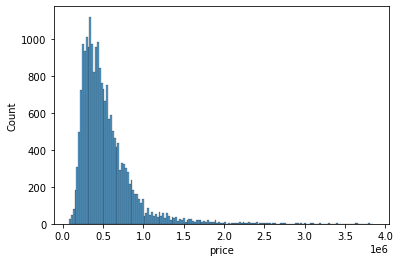

(71224.999, 452500.0]     10912
(452500.0, 830000.0]       8054
(830000.0, 1207500.0]      1675
(1207500.0, 1585000.0]      520
(1585000.0, 1962500.0]      234
(1962500.0, 2340000.0]       86
(2340000.0, 2717500.0]       58
(2717500.0, 3095000.0]       31
(3095000.0, 3472500.0]       20
(3472500.0, 3850000.0]       10
Name: price, dtype: int64
Min 75000.0
Max 3850000.0



bedrooms


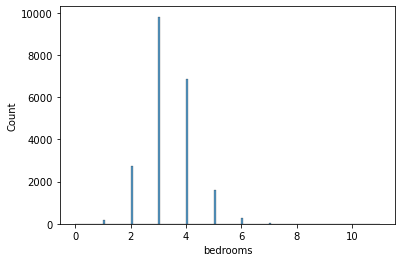

(-0.012, 1.1]     212
(1.1, 2.2]       2760
(2.2, 3.3]       9824
(3.3, 4.4]       6880
(4.4, 5.5]       1594
(5.5, 6.6]        269
(6.6, 7.7]         38
(7.7, 8.8]         13
(8.8, 9.9]          6
(9.9, 11.0]         4
Name: bedrooms, dtype: int64
Min 0
Max 11



bathrooms


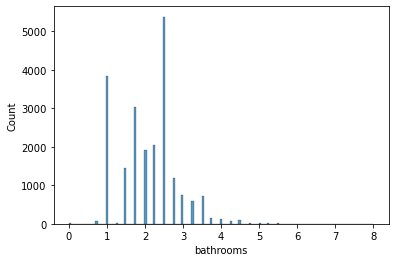

(-0.009000000000000001, 0.8]      86
(0.8, 1.6]                      5307
(1.6, 2.4]                      7024
(2.4, 3.2]                      7317
(3.2, 4.0]                      1611
(4.0, 4.8]                       201
(4.8, 5.6]                        40
(5.6, 6.4]                         9
(6.4, 7.2]                         3
(7.2, 8.0]                         2
Name: bathrooms, dtype: int64
Min 0.0
Max 8.0



sqft_living


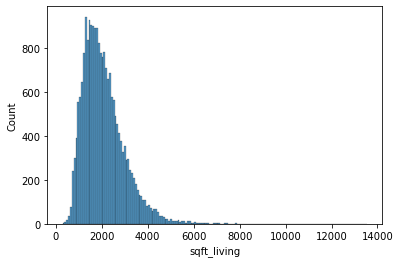

(276.749, 1615.0]      7570
(1615.0, 2940.0]      10713
(2940.0, 4265.0]       2780
(4265.0, 5590.0]        441
(5590.0, 6915.0]         75
(6915.0, 8240.0]         19
(8240.0, 9565.0]          1
(9565.0, 10890.0]         0
(10890.0, 12215.0]        0
(12215.0, 13540.0]        1
Name: sqft_living, dtype: int64
Min 290
Max 13540



sqft_lot


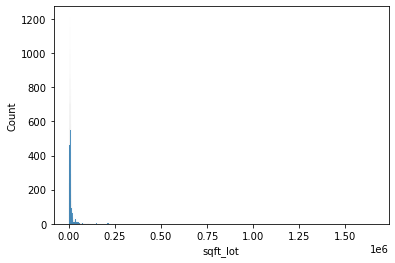

(-1130.84, 165603.9]      21290
(165603.9, 330687.8]        251
(330687.8, 495771.7]         37
(495771.7, 660855.6]         10
(660855.6, 825939.5]          1
(825939.5, 991023.4]          7
(991023.4, 1156107.3]         2
(1156107.3, 1321191.2]        1
(1321191.2, 1486275.1]        0
(1486275.1, 1651359.0]        1
Name: sqft_lot, dtype: int64
Min 520
Max 1651359



floors


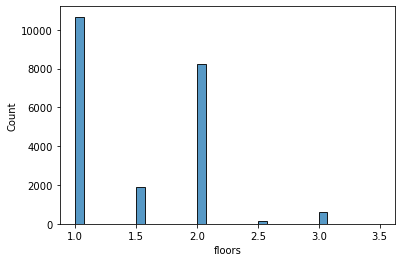

(0.997, 1.25]    10678
(1.25, 1.5]       1910
(1.5, 1.75]          0
(1.75, 2.0]       8231
(2.0, 2.25]          0
(2.25, 2.5]        160
(2.5, 2.75]          0
(2.75, 3.0]        613
(3.0, 3.25]          0
(3.25, 3.5]          8
Name: floors, dtype: int64
Min 1.0
Max 3.5



waterfront


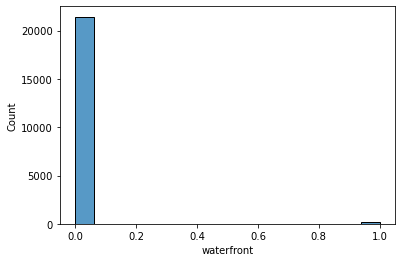

(-0.002, 0.1]    21442
(0.1, 0.2]           0
(0.2, 0.3]           0
(0.3, 0.4]           0
(0.4, 0.5]           0
(0.5, 0.6]           0
(0.6, 0.7]           0
(0.7, 0.8]           0
(0.8, 0.9]           0
(0.9, 1.0]         158
Name: waterfront, dtype: int64
Min 0
Max 1



view


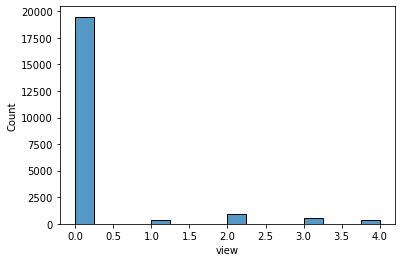

(-0.005, 0.4]    19484
(0.4, 0.8]           0
(0.8, 1.2]         332
(1.2, 1.6]           0
(1.6, 2.0]         962
(2.0, 2.4]           0
(2.4, 2.8]           0
(2.8, 3.2]         509
(3.2, 3.6]           0
(3.6, 4.0]         313
Name: view, dtype: int64
Min 0
Max 4



condition


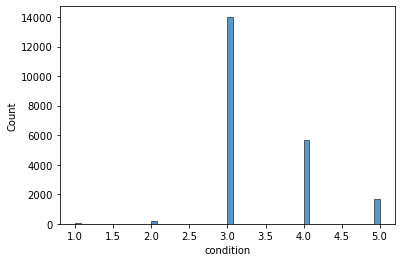

(0.995, 1.4]       30
(1.4, 1.8]          0
(1.8, 2.2]        172
(2.2, 2.6]          0
(2.6, 3.0]      14021
(3.0, 3.4]          0
(3.4, 3.8]          0
(3.8, 4.2]       5677
(4.2, 4.6]          0
(4.6, 5.0]       1700
Name: condition, dtype: int64
Min 1
Max 5



grade


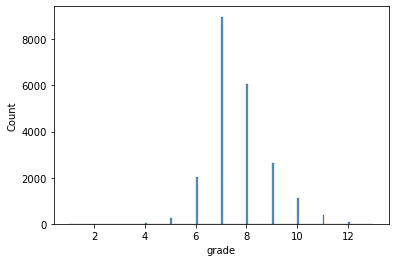

(0.987, 2.2]        1
(2.2, 3.4]          3
(3.4, 4.6]         29
(4.6, 5.8]        242
(5.8, 7.0]      11018
(7.0, 8.2]       6068
(8.2, 9.4]       2615
(9.4, 10.6]      1134
(10.6, 11.8]      398
(11.8, 13.0]       92
Name: grade, dtype: int64
Min 1
Max 13



sqft_above


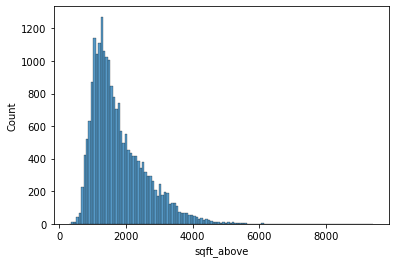

(280.879, 1202.0]    5620
(1202.0, 2114.0]     9988
(2114.0, 3026.0]     4065
(3026.0, 3938.0]     1483
(3938.0, 4850.0]      351
(4850.0, 5762.0]       66
(5762.0, 6674.0]       21
(6674.0, 7586.0]        2
(7586.0, 8498.0]        3
(8498.0, 9410.0]        1
Name: sqft_above, dtype: int64
Min 290
Max 9410



sqft_basement


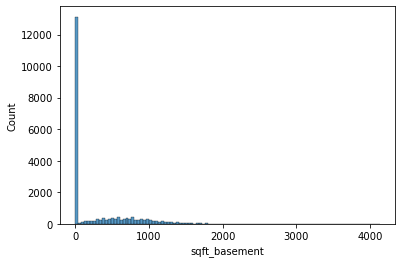

(-4.131, 413.0]     15006
(413.0, 826.0]       3427
(826.0, 1239.0]      2256
(1239.0, 1652.0]      697
(1652.0, 2065.0]      159
(2065.0, 2478.0]       38
(2478.0, 2891.0]       14
(2891.0, 3304.0]        1
(3304.0, 3717.0]        1
(3717.0, 4130.0]        1
Name: sqft_basement, dtype: int64
Min 0
Max 4130



yr_built


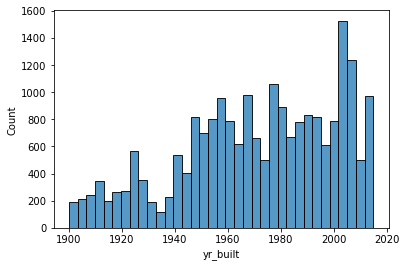

(1899.884, 1911.5]     851
(1911.5, 1923.0]       952
(1923.0, 1934.5]      1079
(1934.5, 1946.0]      1360
(1946.0, 1957.5]      2586
(1957.5, 1969.0]      3218
(1969.0, 1980.5]      2525
(1980.5, 1992.0]      2782
(1992.0, 2003.5]      2658
(2003.5, 2015.0]      3589
Name: yr_built, dtype: int64
Min 1900
Max 2015



renovated


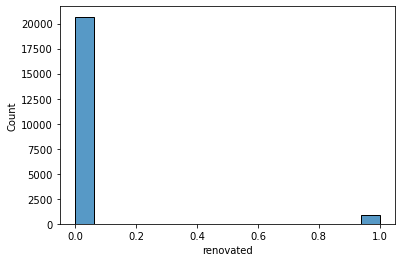

(-0.002, 0.1]    20689
(0.1, 0.2]           0
(0.2, 0.3]           0
(0.3, 0.4]           0
(0.4, 0.5]           0
(0.5, 0.6]           0
(0.6, 0.7]           0
(0.7, 0.8]           0
(0.8, 0.9]           0
(0.9, 1.0]         911
Name: renovated, dtype: int64
Min 0
Max 1



lat


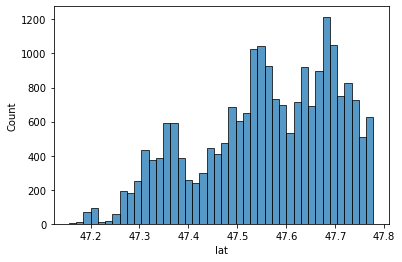

(47.154, 47.218]     181
(47.218, 47.28]      329
(47.28, 47.342]     1428
(47.342, 47.405]    1930
(47.405, 47.467]    1432
(47.467, 47.529]    2584
(47.529, 47.591]    3863
(47.591, 47.653]    2997
(47.653, 47.715]    4019
(47.715, 47.778]    2837
Name: lat, dtype: int64
Min 47.1559
Max 47.7776



long


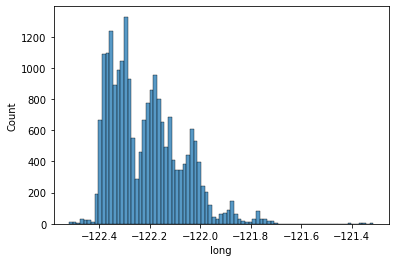

(-122.521, -122.399]     419
(-122.399, -122.278]    8829
(-122.278, -122.158]    5634
(-122.158, -122.037]    3908
(-122.037, -121.917]    2091
(-121.917, -121.797]     483
(-121.797, -121.676]     217
(-121.676, -121.556]       2
(-121.556, -121.435]       2
(-121.435, -121.315]      15
Name: long, dtype: int64
Min -122.519
Max -121.315



sqft_living15


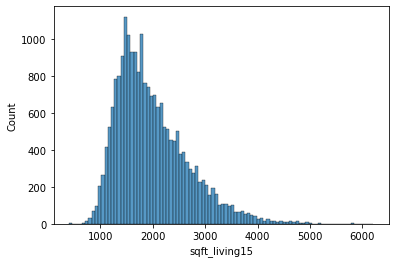

(393.18800000000005, 980.1]     312
(980.1, 1561.2]                6439
(1561.2, 2142.3]               7587
(2142.3, 2723.4]               4200
(2723.4, 3304.5]               2001
(3304.5, 3885.6]                728
(3885.6, 4466.7]                232
(4466.7, 5047.8]                 81
(5047.8, 5628.9]                 12
(5628.9, 6210.0]                  8
Name: sqft_living15, dtype: int64
Min 399
Max 6210



sqft_lot15


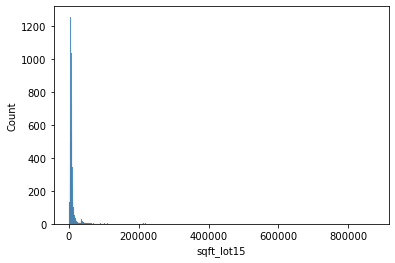

(-219.55, 87705.9]      21203
(87705.9, 174760.8]       196
(174760.8, 261815.7]      166
(261815.7, 348870.6]       21
(348870.6, 435925.5]       10
(435925.5, 522980.4]        1
(522980.4, 610035.3]        1
(610035.3, 697090.2]        0
(697090.2, 784145.1]        0
(784145.1, 871200.0]        2
Name: sqft_lot15, dtype: int64
Min 651
Max 871200





In [8]:
# Check out for outliers
for feature in data.columns:
    print(feature)
    sns.histplot(data[feature])
    plt.show()
    print(data[feature].value_counts(bins=10, sort=False))
    print('Min', min(data[feature]))
    print('Max', max(data[feature]))
    print('\n\n')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21600 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21600 non-null  float64
 1   bedrooms       21600 non-null  int64  
 2   bathrooms      21600 non-null  float64
 3   sqft_living    21600 non-null  int64  
 4   sqft_lot       21600 non-null  int64  
 5   floors         21600 non-null  float64
 6   waterfront     21600 non-null  int64  
 7   view           21600 non-null  int64  
 8   condition      21600 non-null  int64  
 9   grade          21600 non-null  int64  
 10  sqft_above     21600 non-null  int64  
 11  sqft_basement  21600 non-null  int64  
 12  yr_built       21600 non-null  int64  
 13  renovated      21600 non-null  int64  
 14  zipcode        21600 non-null  int64  
 15  lat            21600 non-null  float64
 16  long           21600 non-null  float64
 17  sqft_living15  21600 non-null  int64  
 18  sqft_l

Pearson correlation matrix

We use the Pearson correlation coefficient to examine the strength and direction of the linear relationship between two continuous variables.

The correlation coefficient can range in value from −1 to +1. The larger the absolute value of the coefficient, the stronger the relationship between the variables. For the Pearson correlation, an absolute value of 1 indicates a perfect linear relationship. A correlation close to 0 indicates no linear relationship between the variables.

The sign of the coefficient indicates the direction of the relationship. If both variables tend to increase or decrease together, the coefficient is positive, and the line that represents the correlation slopes upward. If one variable tends to increase as the other decreases, the coefficient is negative, and the line that represents the correlation slopes downward.

<AxesSubplot:title={'center':'Pearson Correlation Matrix'}>

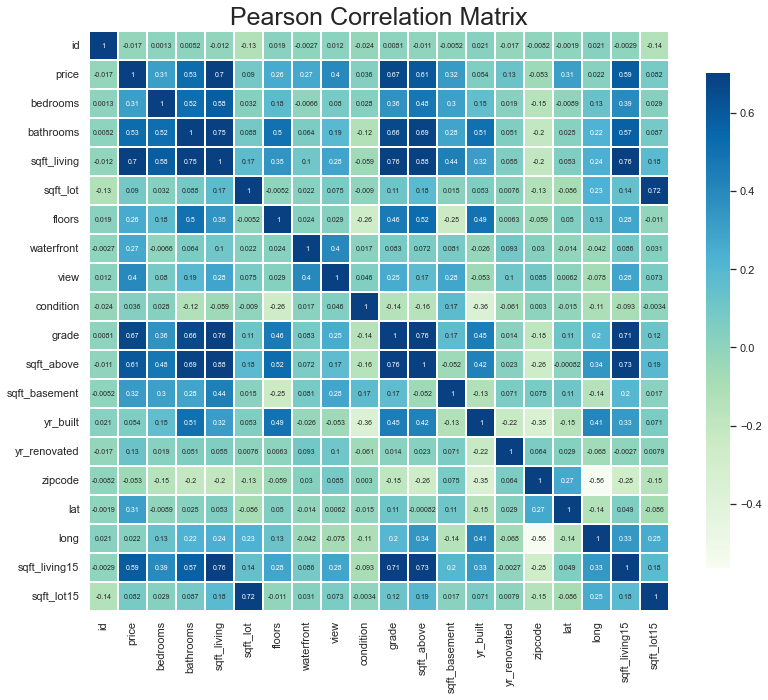

In [4]:
sns.set(style="whitegrid", font_scale=1)
plt.figure(figsize=(13,13))
plt.title('Pearson Correlation Matrix',fontsize=25)
sns.heatmap(data.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="GnBu",
            linecolor='w',annot=True, annot_kws={"size":7}, 
            cbar_kws={"shrink": .7})

Which features are more correlated to the price?


In [10]:
price_corr = data.corr()['price'].sort_values(ascending=False)
print(price_corr)

price            1.000000
sqft_living      0.694332
grade            0.677461
sqft_above       0.598753
sqft_living15    0.597792
bathrooms        0.520003
view             0.397511
lat              0.320394
bedrooms         0.317871
sqft_basement    0.312569
floors           0.264089
waterfront       0.248897
renovated        0.123182
sqft_lot         0.091994
sqft_lot15       0.084420
yr_built         0.054103
condition        0.040820
long             0.024028
zipcode         -0.051128
Name: price, dtype: float64


# Splitting the data

In [11]:
X = data.drop('price', axis=1)
y = data['price']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                    random_state=0)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15120, 18)
(6480, 18)
(15120,)
(6480,)


# Normalizing data

In [10]:
# scaler = MinMaxScaler()

# # fit and transfrom
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Creating model

In [14]:
params = {'iterations':10000,
        'learning_rate':0.01,
        'depth':3,
        'loss_function':'RMSE',
        'eval_metric':'RMSE',
        'random_seed':55,
        #'cat_features':boston_categories,
        'metric_period':200,  
        'od_type':"Iter",  
        'od_wait':20,  
        'verbose':True,
        'use_best_model':True}
model = CatBoostRegressor(**params)

# Training model

In [15]:
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         use_best_model=True,
         plot=True,
         verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 345891.9480508	test: 345907.7598494	best: 345907.7598494 (0)	total: 61.4ms	remaining: 10m 14s
200:	learn: 189988.8717602	test: 190680.6683071	best: 190680.6683071 (200)	total: 423ms	remaining: 20.6s
400:	learn: 154776.2387828	test: 155286.2193118	best: 155286.2193118 (400)	total: 790ms	remaining: 18.9s
600:	learn: 140133.9061283	test: 141310.5918705	best: 141310.5918705 (600)	total: 1.16s	remaining: 18.2s
800:	learn: 132210.0940179	test: 134144.6337262	best: 134144.6337262 (800)	total: 1.64s	remaining: 18.9s
1000:	learn: 127181.4633115	test: 129958.1415207	best: 129958.1415207 (1000)	total: 2.03s	remaining: 18.2s
1200:	learn: 123359.3094657	test: 127261.7334717	best: 127261.7334717 (1200)	total: 2.38s	remaining: 17.4s
1400:	learn: 120007.6008026	test: 125203.4198809	best: 125203.4198809 (1400)	total: 2.73s	remaining: 16.8s
1600:	learn: 117386.9432710	test: 123751.2293790	best: 123751.2293790 (1600)	total: 3.07s	remaining: 16.1s
1800:	learn: 115380.6178454	test: 122672.3821423

# Metrics

$R^2$: compares models prediction to the mean of the targets. that is the expected value

In [16]:
# predictions on the test set
y_pred = model.predict(X_test)

print('MAE: ',mean_absolute_error(y_test,y_pred)) # sum(abs(y_test - y_pred) / len(y_test))
print('MSE: ',mean_squared_error(y_test,y_pred)) # sum((y_test - y_pred)**2 / len(y_test))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y_pred)))
print('Variance Regression Score: ',explained_variance_score(y_test,y_pred))
#print('Accuracy', accuracy_score(y_test, y_pred))
print('R^2 score', model.score(X_test,y_test)) # Calculates r^2


MAE:  67378.75256223505
MSE:  12493686073.656778
RMSE:  111775.15857137837
Variance Regression Score:  0.896715658462857
R^2 score 0.8967156311766572


# SHAP

In [17]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [18]:
shap_values2 = explainer(X)

## Local Explanation

In [19]:
sample = 10
X.iloc[sample:sample+1,:]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15
10,3,2.5,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925


In [20]:
model.predict(X.iloc[sample:sample+1,:])

array([691137.75768051])

In [21]:
y[sample]

662500.0

In [25]:
shap_values2[sample]

.values =
array([  6445.6665504 ,    954.19074073, 177898.46191639,   9353.44427428,
         2995.15805205,  -6073.05016675, -10906.61842913, -11017.73548305,
       -17174.70422995,   5308.78035444, -90282.66135448, -29318.29415725,
        -2681.83657411,   6035.10626459, 139414.82771066, -31511.97459231,
        10523.58385478,  -5447.69598461])

.base_values =
536623.1089338156

.data =
array([ 3.00000e+00,  2.50000e+00,  3.56000e+03,  9.79600e+03,
        1.00000e+00,  0.00000e+00,  0.00000e+00,  3.00000e+00,
        8.00000e+00,  1.86000e+03,  1.70000e+03,  1.96500e+03,
        0.00000e+00,  9.80070e+04,  4.76007e+01, -1.22145e+02,
        2.21000e+03,  8.92500e+03])

In [26]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample,:], 
                X_test.iloc[sample,:])

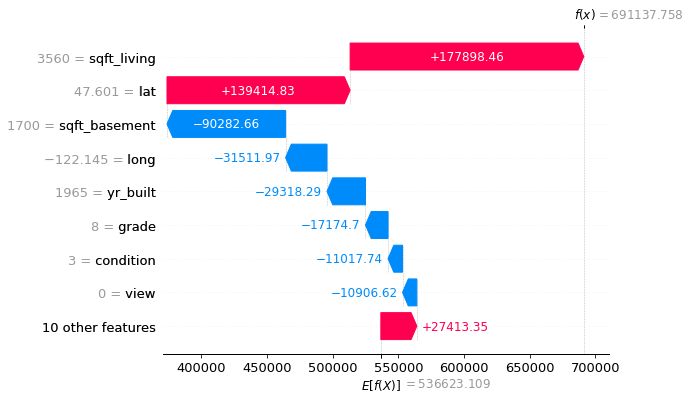

In [27]:
shap.plots.waterfall(shap_values2[sample], max_display=9)

## Global Explanation

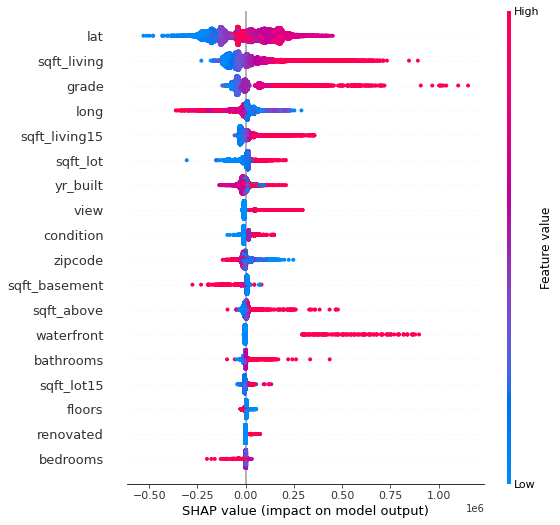

In [28]:
shap.summary_plot(shap_values, X, max_display=22)#, show=False)
# plt.gcf().axes[-1].set_aspect(150)
# plt.gcf().axes[-1].set_box_aspect(100)

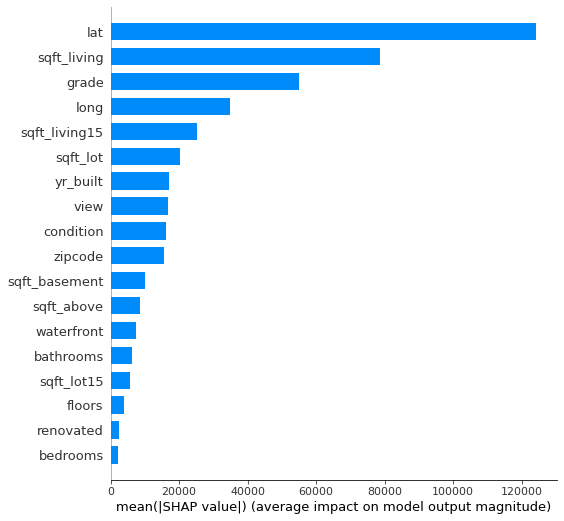

In [29]:
shap.summary_plot(shap_values2, X,plot_type="bar", max_display=22) 